Bagian 1: Inisialisasi & Optimasi M3
Langkah pertama adalah memastikan PyTorch menggunakan MPS (Metal Performance Shaders) agar proses OCR berjalan cepat di GPU MacBook M3 Anda

In [8]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Cek ketersediaan GPU M3 (MPS)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Menggunakan Device: {device}")

Menggunakan Device: mps


Bagian 2: Robust Preprocessing (Pembersihan Kertas)
Karena dataset Anda adalah tulisan di kertas, Anda perlu menghilangkan bayangan dan garis buku agar model tidak bingung.

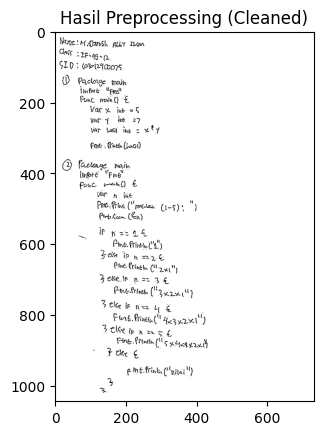

In [9]:
def clean_handwriting(image_path):
    # Load image
    img = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Adaptive Thresholding: Sangat penting untuk kertas dengan pencahayaan tidak rata
    cleaned = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Noise Removal (Median Blur)
    # cleaned = cv2.medianBlur(cleaned, 3)
    
    return gray, cleaned

# Visualisasi Hasil Preprocessing
original_gray, cleaned_img = clean_handwriting('../../dataset/TP_MOD05_103012400075_MDANOSHABBYIHSAN.png')
plt.imshow(cleaned_img, cmap='gray')
plt.title("Hasil Preprocessing (Cleaned)")
plt.show()

Bagian 3: Line Segmentation (Pemotongan Baris)
Model TrOCR bekerja paling baik jika membaca satu baris teks dalam satu waktu. Fungsi ini akan memotong blok pseudocode Anda menjadi potongan-potongan baris.

In [10]:
def get_line_segments(cleaned_img):
    # Invert image (teks jadi putih, background hitam)
    inverted = cv2.bitwise_not(cleaned_img)
    
    # Hitung proyeksi horizontal (jumlah piksel putih per baris)
    projection = np.sum(inverted, axis=1)
    
    # Tentukan threshold untuk memisahkan baris
    lines = []
    start_y = None
    for y, val in enumerate(projection):
        if val > 0 and start_y is None:
            start_y = y
        elif val == 0 and start_y is not None:
            if y - start_y > 5: # Minimal tinggi baris 5 piksel
                lines.append(cleaned_img[start_y:y, :])
            start_y = None
    return lines

line_crops = get_line_segments(cleaned_img)
print(f"Terdeteksi {len(line_crops)} baris pseudocode.")

Terdeteksi 22 baris pseudocode.


Bagian 4: Core OCR Engine (TrOCR)
Inilah jantung dari tugas Anda. Kita akan menggunakan model microsoft/trocr-base-handwritten yang sangat kuat untuk tulisan tangan.

In [11]:
# Load Model ke GPU M3
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)

def transcribe_lines(line_images):
    transcriptions = []
    for line_img in line_images:
        # Convert ke RGB (format yang diminta TrOCR)
        image = Image.fromarray(line_img).convert("RGB")
        
        # Inference
        pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        transcriptions.append(text)
    return transcriptions

# Jalankan Transkripsi
raw_results = transcribe_lines(line_crops)
for i, line in enumerate(raw_results):
    print(f"Baris {i+1}: {line}")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baris 1: Name : MICHANISH ATAY IUPAN 2 0 0 0 0 0 0 0 0
Baris 2: a b. Hamilton 1887
Baris 3: O packose , main #
Baris 4: a fine mailing it has been considered to
Baris 5: 2 1 . Vari x. int.e.S.00050000500005
Baris 6: a great job at the age of the same time
Baris 7: # far boat in. x.y.0003000
Baris 8: 1961-Fort. Britti (LuellaD. 022222222222222222
Baris 9: G. Dickson with the first time
Baris 10: a fine until # E.000
Baris 11: 1961 War in the 1960s 1961 1962 1963
Baris 12: 2nd. Republican class ) : " p.0008
Baris 13: " A.F.R.C.S.S.
Baris 14: 1961- That . Friends . "
Baris 15: 1952 Belle is a single 1-000
Baris 16: 1953 Raleigh Cliffs ,
Baris 17: 36 3/2 Elseira in # 3.6.00050000500005
Baris 18: 1953 Pittsburgh Vikings , up a total of
Baris 19: 0 0
Baris 20: 1962 1963 Pittsburgh University 1963 1965
Baris 21: a b. B. B. B. B. B.
Baris 22: a b. B. B.O. B.O. B.O. B.O
